In [1]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

**Building a Decision Tree Classifier**

In [3]:
# Load data
data = pd.read_csv("Data/cleaned_bank_data.csv")

# data (as pandas dataframes) 
X = data.drop(columns=['y', 'duration_group'])
y = data['y']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Display columns
print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Preprocessing pipelines: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Define model
dt = DecisionTreeClassifier(random_state=42)

# Hyperparameter grid
parameter_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_leaf': [1, 5, 20],
    'classifier__min_samples_split': [2, 10, 50],
    'classifier__class_weight': [None, 'balanced']  
}

# Pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ("smote", SMOTE(random_state=42)),
    ('classifier', dt)
])


# Grid search with 5-fold CV
grid_search = GridSearchCV(pipeline, 
                        parameter_grid, 
                        cv=5, n_jobs=-1, 
                        scoring='f1_macro', verbose=1)
grid_search.fit(X_train, y_train)

# Best params and score
print("Best parameters:", grid_search.best_params_)
print("Best CV F1 Score:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob, pos_label='yes')

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'age_group']
Numeric columns: ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 50}
Best CV F1 Score: 0.7489117841384989
Test Accuracy: 0.8771425411920822
Classification Report:
               precision    recall  f1-score   support

          no       0.96      0.90      0.93      7985
         yes       0.48      0.71      0.57      1058

    accuracy                           0.88      9043
   macro avg       0.72      0.80      0.75      9043
weighted avg       0.90      0.88      0.89      9043

Confusion Matrix:
 [[7181  804]
 [ 307  751]]
Test ROC AUC: 0.8950639964110401


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327


c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.8558000663496628
ROC AUC: 0.9338273677133282

Classification Report:
               precision    recall  f1-score   support

          no       0.98      0.85      0.91      7985
         yes       0.44      0.88      0.59      1058

    accuracy                           0.86      9043
   macro avg       0.71      0.87      0.75      9043
weighted avg       0.92      0.86      0.87      9043


Confusion Matrix:
 [[6808 1177]
 [ 127  931]]


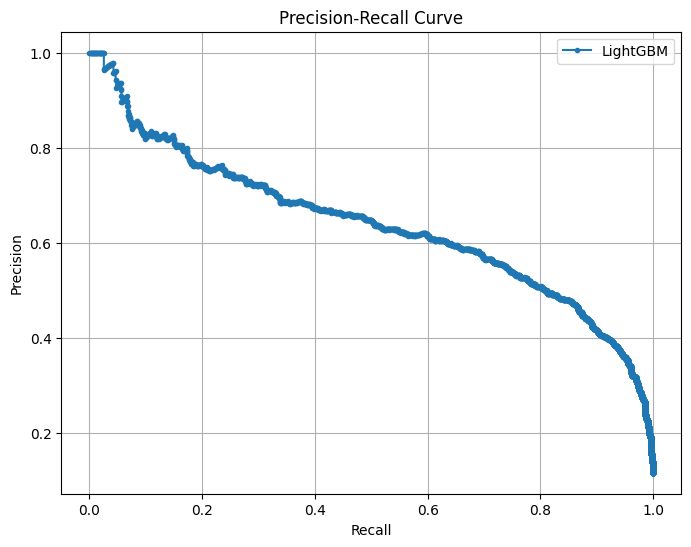

Threshold=0.3: Precision=0.374, Recall=0.940, F1=0.535
Threshold=0.5: Precision=0.442, Recall=0.880, F1=0.588
Threshold=0.7: Precision=0.530, Recall=0.764, F1=0.626


In [7]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

# LightGBM classifier
lgb_clf = lgb.LGBMClassifier(
    objective="binary",        # since y is yes/no
    is_unbalance=True,         # handles class imbalance automatically
    boosting_type="gbdt",      # gradient boosting decision trees
    n_estimators=200,          # number of boosting iterations (still light)
    learning_rate=0.05,        # smaller step size
    max_depth=-1,              # no limit, let it grow
    num_leaves=31,             # controls complexity
    random_state=42
)

# Create a pipeline with preprocessor and classifier
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb_clf)
])


# Fit model
lgb_pipeline.fit(X_train, y_train)

# Predictions
y_pred = lgb_pipeline.predict(X_test)
y_proba = lgb_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test.map({'no':0, 'yes':1}), y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Preccision Recall curve
precision, recall, thresholds = precision_recall_curve(y_test.map({"no": 0, "yes": 1}), y_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='LightGBM')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# Thresholds tuning
def evaluate_threshold(threshold):
    y_pred_adj = (y_proba >= threshold).astype(int)
    prec = precision_score(y_test.map({"no": 0, "yes": 1}), y_pred_adj)
    rec = recall_score(y_test.map({"no": 0, "yes": 1}), y_pred_adj)
    f1 = f1_score(y_test.map({"no": 0, "yes": 1}), y_pred_adj)
    return prec, rec, f1

for t in [0.3, 0.5, 0.7]:
    prec, rec, f1 = evaluate_threshold(t)
    print(f"Threshold={t}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")